## V.1 Exploring the green reds

In [2]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

import warnings        # used to remote warning messages
warnings.filterwarnings(action='once')

import datetime as dt  # used to give a filename of a figure being saved
import random as rd    # used to initialize weights
import itertools as it # used to create infinite counter in Perceptron.fit()
import math            # used to check for float equality in linspace
plt.tight_layout()
# %config InlineBackend.figure_format='svg'
%matplotlib inline

In [3]:
# load data with proper data tyles
df = pd.read_csv('resources/winequality-red.csv', delimiter=';', dtype=pd.np.float32)
df['quality'] = df['quality'].astype(pd.np.int16)

In [4]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float32
volatile acidity        1599 non-null float32
citric acid             1599 non-null float32
residual sugar          1599 non-null float32
chlorides               1599 non-null float32
free sulfur dioxide     1599 non-null float32
total sulfur dioxide    1599 non-null float32
density                 1599 non-null float32
pH                      1599 non-null float32
sulphates               1599 non-null float32
alcohol                 1599 non-null float32
quality                 1599 non-null int16
dtypes: float32(11), int16(1)
memory usage: 71.9 KB


**a) scatter matrix**

In [6]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False, remove_neutral=False):
    side = wine_data.shape[1]  # calculate side of a scatter matrix
    if 'quality' not in wine_data.columns:
        raise ValueError("Wine dataset must contain quality feature")
    # C1 for bad, C2 for good, C3 for neutral
    data = wine_data.query('quality <= {} | quality >= {}'.format(bad_threshold, good_threshold)) if remove_neutral else wine_data
    qual_color = data['quality'].apply(lambda x: 'C3' if x <= bad_threshold else ('C2' if x >= good_threshold else 'C1'))    
    fig, axis = plt.subplots(side, side, figsize=(20, 20))
    fig.subplots_adjust(hspace=0, wspace=0)  # to remove gaps between plots
    plot_kw = {"s": 15, "alpha":.5}  # config for each plot
    for ax in axis.ravel():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            if i != j:  # create scatterplot
                axis[i, j].scatter(y=data.iloc[:, i], x=data.iloc[:, j], c=qual_color, **plot_kw)
            else:
                axis[i, j].text(0.5, 0.5, data.columns[i],
                                horizontalalignment='center', verticalalignment='center',
                                fontsize=15)
                
    from matplotlib.patches import Patch  # to create legend artists manually
    legend_elems = [Patch([0], [0], color='C3', label='bad wine'),
                    Patch([0], [0], color='C2', label='good wine')]
    if not remove_neutral:
        legend_elems.append(Patch([0], [0], color='C1', label='neutral wine'))
    fig.legend(handles=legend_elems)
    if save_plot:
        plt.savefig('scatter_matrix_{}.png'.format(str(dt.datetime.now())[:-7]))

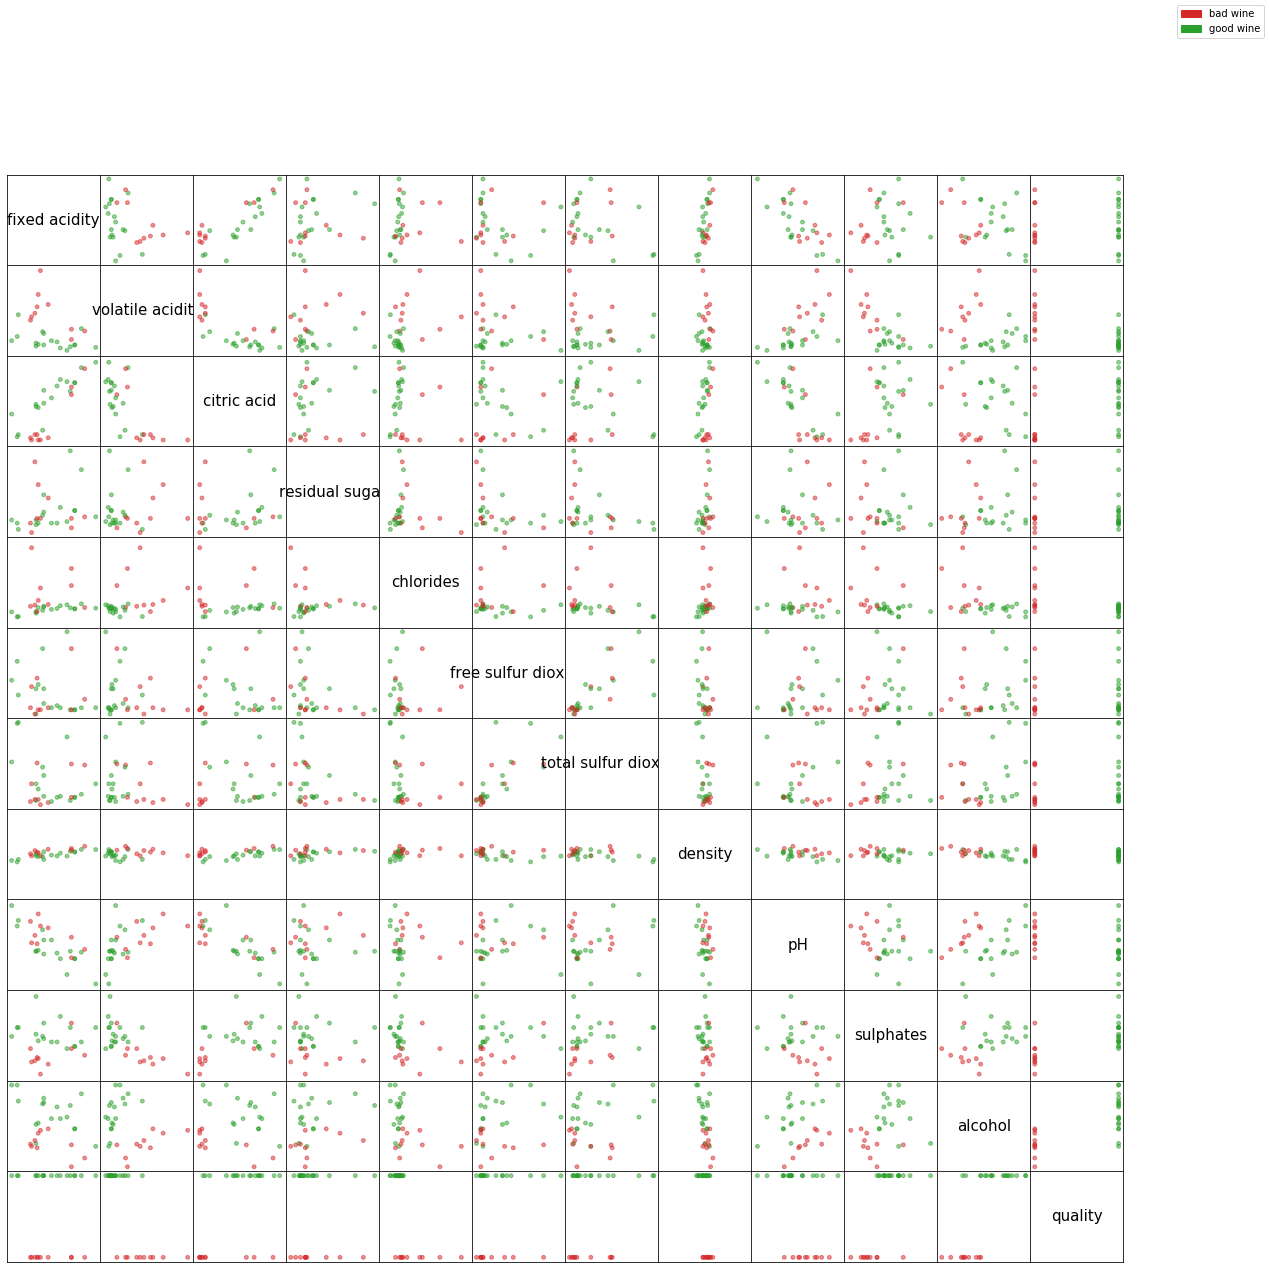

In [1021]:
plot_scatter_matrix(df, 8, 3, save_plot=False, remove_neutral=True)

**b) > Which factors will be most useful for perceptron to distinguish good wine (quality >= 8) from bad one (quality <= 3)?**
<br/>
<br />
Any pair of features will give a decent linear decision boundary. Most useful, when looking at scatter matrix, are `volatile acidity`, `alcohol`, `density`, `pH`, and `suplhates`.

## V.2 Learning to perceptron
<br />

**a) Perceptron implementation**

In [7]:
# first we create a basic class-interface to be specialized later
class Model:
    def __init__(self):
        """
        Base class for learning models
        """
        pass
    
    def __str__(self):
        return self.__class__.__name__
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass

In [8]:
class Perceptron(Model):
    def __init__(self, alpha=.01, activation_function='heaviside'):
        super().__init__()
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.activation_function = activation_function
        self.performance = []
    
    def fit(self, X, y, epochs=0):
        """
        Fit Perceptron to data
        
        This function will infer input shape, initialize weights appropriatedly
        and fit model's parameters to data so as to minimize misclassification error.
        @param X: dataset of shape (n_samples, n_features)
        @param y: target values of shape (n_samples,)
        @param epochs: # of iterations over a whole dataset. If epochs=0, update weights
                       until no classification error made (unless non-separable classes)
        """
        if epochs < 0:
            raise ValueError("epochs >= 0")
        if X.shape[0] != y.shape[0]:
            raise ValueError("number of samples in X must equal to y")
        self._init_weights(X.shape[1])  # initialize weights using # of features
        last_n_errors = 0
        cnt_same_errors = 0
        for epoch in (range(epochs) if epochs > 0 else it.count()):
            n_errors = 0
            for (i, x), y_true in zip(X.iterrows(), y):
                y_pred = sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias) >= 0
                if abs(y_true - y_pred) == 0:  # no error - skip update
                    continue
                n_errors += 1
                for j in range(len(self.weights)):
                    self.weights[j] += self.alpha * (y_true - y_pred) * x[j]
                self.bias += self.alpha * (y_true - y_pred)
            self.performance.append((epoch, n_errors, tuple(self.weights), self.bias))
            if n_errors == 0:
                warnings.warn("Zero classification errors. Early stopping...")
                break
            if n_errors == last_n_errors:
                cnt_same_errors += 1
            else:
                last_n_errors = n_errors
                cnt_same_errors = 0
            if cnt_same_errors > 100:
                warnings.warn("Linearly non-separable classes suspected. Stopping...")
                break
    
    def predict(self, X):
        """
        Predict class, given data
        """
        if self.bias is None or self.weights is None:
            raise ValueError("Fit perceptron to data before using it for prediction")
        y = []
        for i, x in X.iterrows():
            y.append(int(sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias) >= 0))
        return pd.Series(y, index=X.index)
    
    def _init_weights(self, shape):
        self.weights = [rd.gauss(0, 1) / 100 for _ in range(shape)]
        self.bias = 1

**b) Train Perceptron**

In [9]:
def train_perceptron(data, learning_rate=.01, epochs=0):
    """
    Train Perceptron model and return it's performance
    
    @param data: pd.DataFrame that has training data and target feature as a last column
    """
    if 'quality' not in data.columns:
        raise ValueError("<data> must contain target column `quality`")
    p = Perceptron(learning_rate)
    X = data.loc[:, [col for col in data.columns if col not in ['quality', 'pred']]]
    y = data['quality']
    p.fit(X, y, epochs)
    return p.performance

**c) Plot model performance**

In [10]:
# some tools needed to plot the decision boundary
def linspace(start, stop, n_steps=100):
    """
    Return list of evenly-spaced values in interval [start, stop]
    """
    l = []
    step = (stop - start)/(n_steps - 1)
    for _ in range(n_steps - 1):
        l.append(start)
        start += step
    l.append(stop)
    return l

predict = lambda x, weights, bias: int(sum([w * x_j for w, x_j in zip(weights, x)], bias) >= 0)

In [11]:
def plot_performance(performance, wine_data, good_thresh, bad_thresh,
                     epoch=-1, save_plot=False, db_features=None):
    """
    Plot the performance of Perceptron or ADALINE.
    This function, given performance of a model, will produce a two-plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    
    Note:
    decision boundary is calculated at the end of <epoch>. Hence, number of classification
    errors can differ from what is observed on the plot, because weights are updated after
    each error separatedly (truly on-line algorithm), and not at the end.

    @param performance: list of (epoch, classification errors, weights, bias)-tuples
    @param wine_data: dataset that was used to train perceptron
    @param good_thresh: threshold for wine to be considered good (inclusive)
    @param bad_thresh: threshold for wine to be considered bad (inclusive)
    @param epoch: plot decision boundary for specified epoch. If epoch < 0, plot for
                  the last epoch in <performance>
    @param save_plot: if True, save figure to file
    """
    errors = [epoch[1] for epoch in performance]
    epochs = [epoch[0] for epoch in performance]
    fig, axis = plt.subplots(ncols=2, figsize=(16, 8))
    artists = []
    # classification errors
    err_art = axis[0].plot(epochs, errors, 'bo--')
    axis[0].set_title("Error as a function of epoch")
    axis[0].set_xlabel("epoch")
    axis[0].set_ylabel("classification errors")
    artists.append(err_art)
    # decision boundary
    if db_features is None and (len(wine_data.columns) != 3 or 'quality' not in wine_data.columns):
        warnings.warn("Decision boundary can be rendered only for 2-feature dataset")
        if save_plot:
            plt.savefig('performance_plot_{}.png'.format(str(dt.datetime.now())[:-7]))
        plt.show()
        return
    epoch, _, weights, bias = performance[-1 if epoch < 0 or epoch >= len(performance) else epoch]
    xlabel, ylabel = db_features if db_features is not None else wine_data.columns[:2]
    # Firstly, plot scatterplot to use it's limits
    f = axis[1].scatter(wine_data[xlabel], wine_data[ylabel], c=wine_data.quality,
                           s=15, alpha=.7, cmap='PiYG')
    axis[1].set_title("Decision boundary on epoch: {}".format(epoch))
    axis[1].set_xlabel(xlabel)
    axis[1].set_ylabel(ylabel)
    x_min, x_max = f.axes.get_xlim()
    y_min, y_max = f.axes.get_ylim()
    # Generating meshgrid without numpy is pain in the arse...
    xx, yy = linspace(x_min, x_max, 500), linspace(y_min, y_max, 500)
    Z = pd.DataFrame([[predict((x, y), weights, bias) for x in xx] for y in yy])
    db_fill_art = axis[1].contourf(xx, yy, Z, cmap='PiYG', alpha=.3)
    db_art = axis[1].contour(xx, yy, Z, levels=[0, 1], cmap='tab10')
    artists.append(db_fill_art)
    artists.append(db_art)
    # add legend manually
    from matplotlib.lines import Line2D  # to create legend artists manually
    legend_elems = [Line2D([0], [0], lw=1, color='blue', label='Decision Boundary'),
                    Line2D([0], [0], marker='o', lw=0, color='C2', label='good wines'),
                    Line2D([0], [0], marker='o', lw=0, color='#c61d94', label='bad wines')]
    axis[1].legend(handles=legend_elems, loc='upper left')
    if save_plot:
        plt.savefig('performance_plot_{}.png'.format(str(dt.datetime.now())[:-7]))
    plt.show()
    return iter(artists)

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning:

Zero classification errors. Early stopping...



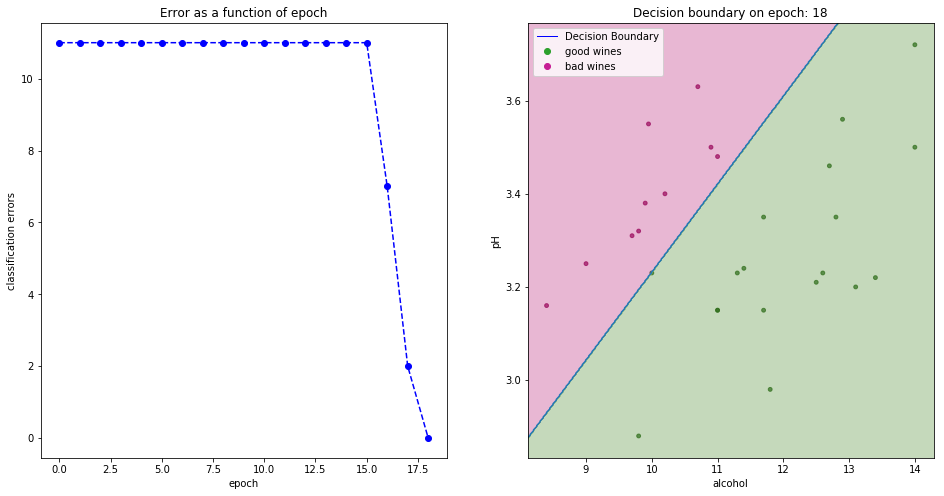

In [548]:
# extracting data
bad_threshold, good_threshold = 3, 8
small_df = df.query('quality <= {} | quality >= {}'.format(bad_threshold, good_threshold))[['alcohol', 'pH', 'quality']]
small_df['quality'] = small_df['quality'].map(lambda x: 0 if x <= bad_threshold else 1)
# train perceptron
perf = train_perceptron(small_df, epochs=500)
# plot performance
plot_performance(perf, small_df, good_threshold, bad_threshold, 1000, True)

**d) Feature Scaling**

In [12]:
# first, let's specialize model for transformers
class TransformerMixin(object):
    def fit_transform(self, X, y=None, **fit_params):
        """
        Fit to data, then transform it.
        """
        pass
    
    def transform(self, X):
        """
        Transform data, using fitted parameters
        """

In [13]:
class StandardScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Standard Scaler transforms each feature of X to have zero mean and unit variance:
        X = (X - μ) / σ
        
        Cons:
            * Assumes data is Normally-distributed
            * Small variance can lead to unstable results
        """
        super().__init__()
        self.mus = []
        self.sigmas = []

    def fit(self, X):
        """
        Estimate mean and standard deviation for each feature in <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            return X
        if len(X.shape) == 1:
            mu = sum(X)/X.shape[0]
            var = sum([math.pow(x - mu, 2) for x in X])/(X.shape[0] - 1)
            sigma = math.sqrt(var)
            self.mus.append(mu)
            self.sigmas.append(sigma)
        else:
            nrows, ncols = X.shape
            for i in range(ncols):
                mu = sum(X.iloc[:, i])/X.shape[0]
                var = sum([math.pow(x - mu, 2) for x in X.iloc[:, i]])/(X.shape[0] - 1)
                sigma = math.sqrt(var)
                self.mus.append(mu)
                self.sigmas.append(sigma)

    def fit_transform(self, X):
        """

        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted sample mean and standard deviation to transform <X>
        """
        if len(self.mus) == 0 or len(self.sigmas) == 0 or len(self.mus) != len(self.sigmas):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            mu = self.mus[0]
            sigma = self.sigmas[0]
            if sigma == 0 or (mu == 0 and sigma == 1):
                return X.copy()
            return X.apply(lambda x: (x - mu)/sigma)
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, mu, sigma in zip(range(ncols), self.mus, self.sigmas):
            if (mu == 0 and sigma == 1) or sigma == 0:
                continue
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - mu)/sigma)
        return Xc
    
    def _reset_estimates(self):
        self.mus = []
        self.sigmas = []


In [14]:
class MinMaxScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Min-Max scaling transforms every feature of <X> in [0, 1] range:
        X = (X - min(X))/(max(X) - min(X))
        
        Cons:
            * Suppresses outliers
            * May result in underflow
        Notes:
            It doesn't really matter if one fits estimates on train data,
            and then uses it to scale test dataset as a part of preprocessing
            pipeline. If you really need to remove the possibility of transformed
            data to be outside of [0, 1], use scaling range algorithm.
        """
        super().__init__()
        self.mins = []
        self.maxs = []

    def fit(self, X):
        """
        Calculate min and max for each feature of <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            warnings.warn("X is too small to require scaling")
            return X
        if len(X.shape) == 1:
            self.mins.append(min(X))
            self.maxs.append(max(X))
        else:
            for i in range(X.shape[1]):
                self.mins.append(min(X.iloc[:, i]))
                self.maxs.append(max(X.iloc[:, i]))

    def fit_transform(self, X):
        """
        Fit estimates for <X> and use them for transformation
        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted min and max of every feature to transform <X>
        """
        if len(self.mins) == 0 or len(self.maxs) == 0 or len(self.mins) != len(self.maxs):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if any([min == max for min, max in zip(self.mins, self.maxs)]):
            warnings.warn("min(X) == max(x): MinMax Scaling is not applicable")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            min = self.mins[0]
            max = self.maxs[0]
            if min == 0 and max == 1:
                return X.copy()
            return X.apply(lambda x: (x - min)/(max - min))
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, min, max in zip(range(ncols), self.mins, self.maxs):
            if min == 0 and max == 1:
                continue
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - min)/(max - min))
        return Xc
    
    def _reset_estimates(self):
        self.mins = []
        self.maxs = []

In [15]:
class RobustScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Robust Scaler is similar to MinMaxScaler, but uses first and third quantiles
        instead of min/max:
        X = (X - Q1(X))/IQR(X)
        
        Cons:
            * Uses less data for actual scaling
        Notes:
            Using quantiles makes it resilient to outliers
        """
        super().__init__()
        self.q1s = []
        self.q3s = []

    def fit(self, X):
        """
        Calculate min and max for each feature of <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            warnings.warn("X is too small to require scaling")
            return X
        if len(X.shape) == 1:
            self.q1s.append(X.quantile(.25))
            self.q3s.append(X.quantile(.75))
        else:
            for i in range(X.shape[1]):
                self.q1s.append(X.iloc[:, i].quantile(.25))
                self.q3s.append(X.iloc[:, i].quantile(.75))

    def fit_transform(self, X):
        """
        Fit estimates for <X> and use them for transformation
        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted min and max of every feature to transform <X>
        """
        if len(self.q1s) == 0 or len(self.q3s) == 0 or len(self.q1s) != len(self.q3s):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if any([q1 == q3 for q1, q3 in zip(self.q1s, self.q3s)]):
            warnings.warn("Q1(X) == Q3(x): Robust Scaling is not applicable")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            q1 = self.q1s[0]
            q3 = self.q3s[0]
            return X.apply(lambda x: (x - q1)/(q3 - q1))
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, q1, q3 in zip(range(ncols), self.q1s, self.q3s):
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - q1)/(q3 - q1))
        return Xc
    
    def _reset_estimates(self):
        self.q1s = []
        self.q3s = []

In [16]:
def prep_data(data, feature_labels, target_label, good_thresh, bad_thresh, scaler=None):
    """
    Prepare data for model training
    
    This function consists of the following steps:
    1) Subset data, based on good/bad threshold of target
    2) Encode target values to 0/1 (binary classification requirement)
    3) Scale features, if <scaler> provided
    
    @returns: concatenated dataframe of features and target as a last column
    """
    sub_df = data.query('quality <= {} | quality >= {}'.format(bad_thresh, good_thresh)) \
                .loc[:, feature_labels + [target_label]]
    sub_df[target_label] = sub_df[target_label].map(lambda x: 0 if x <= bad_thresh else 1)
    if scaler is None:
        return sub_df
    X = scaler.fit_transform(sub_df[feature_labels])
    return pd.concat([X, sub_df[target_label]], axis=1)

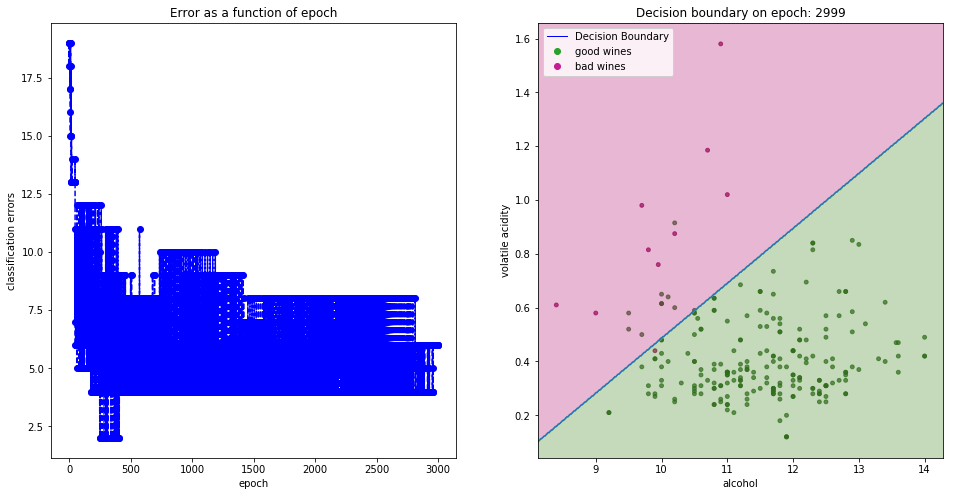

In [537]:
rd.seed(42)  # set seed for reproducibility
bad_threshold, good_threshold = 3, 7
df_raw = prep_data(df, ['alcohol', 'volatile acidity'], 'quality', good_threshold, bad_threshold)
# train perceptron
raw_perf = train_perceptron(df_raw, epochs=500)
plot_performance(raw_perf, df_raw, good_threshold, bad_threshold, -1, False)

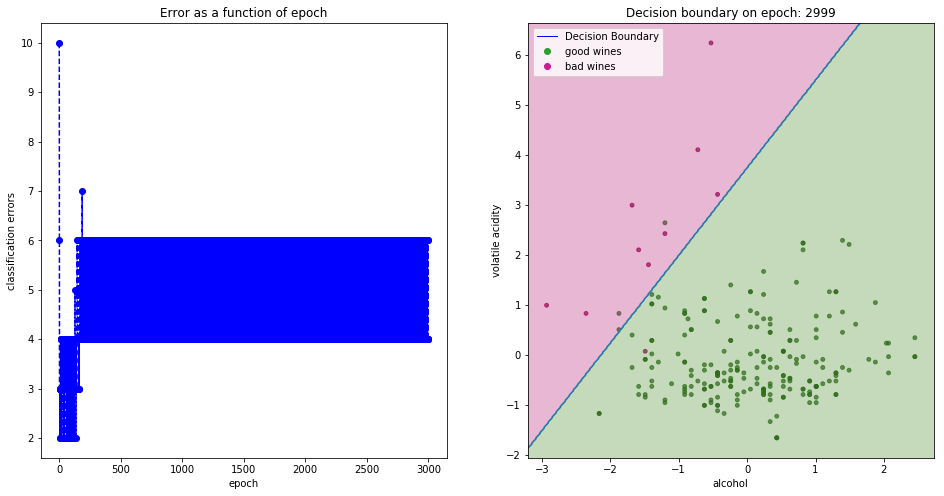

In [216]:
# apply standard scaling for all features from `df_raw`, expect for the target
df_norm = prep_data(df, ['alcohol', 'volatile acidity'], 'quality',
                    good_threshold, bad_threshold, StandardScaler())
norm_perf = train_perceptron(df_norm, epochs=3000)
plot_performance(norm_perf, df_norm, good_threshold, bad_threshold, -1, False)

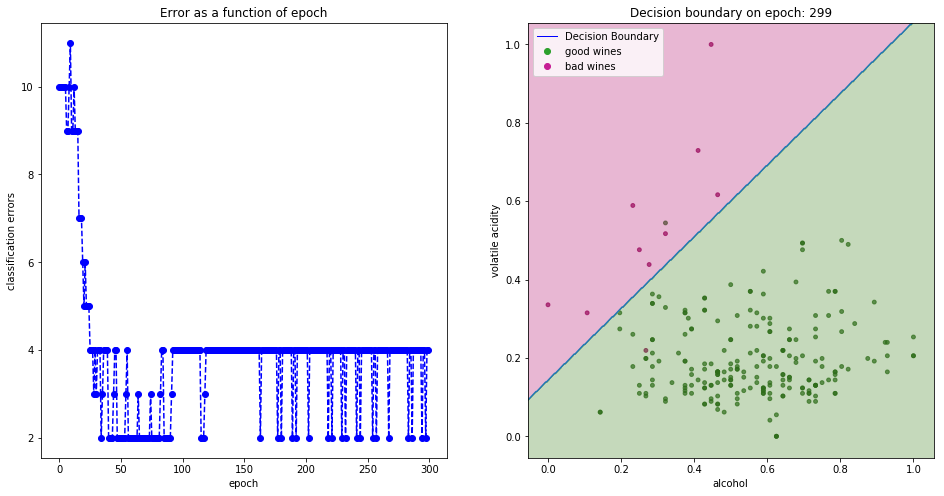

In [1004]:
# apply minmax scaling for all features
df_mm = prep_data(df, ['alcohol', 'volatile acidity'], 'quality',
                  good_threshold, bad_threshold, MinMaxScaler())
mm_perf = train_perceptron(df_mm, epochs=300)
plot_performance(mm_perf, df_mm, good_threshold, bad_threshold, -1, False)

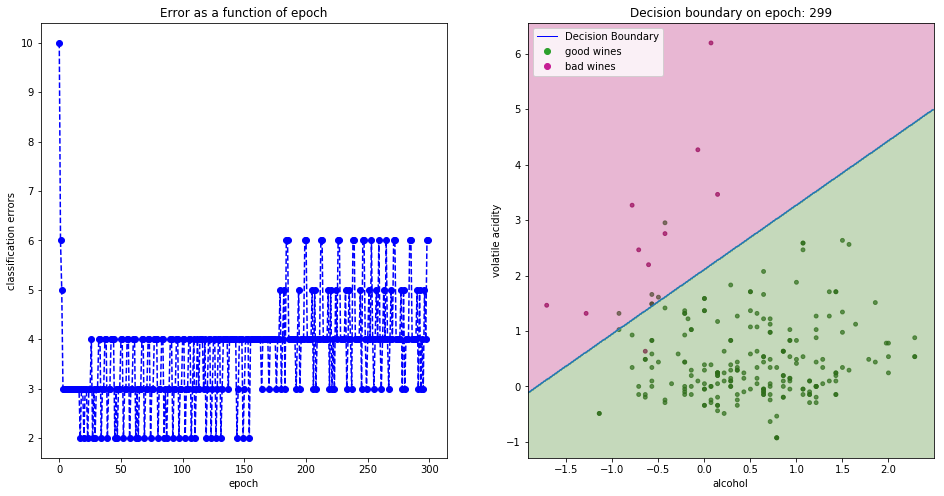

In [1005]:
# apply robust (IQR) scaling
df_rob = prep_data(df, ['alcohol', 'volatile acidity'], 'quality',
                   good_threshold, bad_threshold, RobustScaler())
rob_perf = train_perceptron(df_rob, epochs=300)
plot_performance(rob_perf, df_rob, good_threshold, bad_threshold, -1, False)

## V.3 ADALINE

<br />

**a) ADALINE vs. Perceptron**

Although both of this models look similar, there are subtle differences in loss function and update rule:
* ADALINE minimizes Mean Squared Error (MSE), while Perceptron minimizes Classification Errors
* To minimize MSE ADALINE uses Gradient Descent. Perceptron uses Rosenblatt learning rule

**b) ADALINE implementation**

In [17]:
class Adaline(Model):
    def __init__(self, alpha=.01, activation_function='sgn', batch_size=-1, random_state=None):
        super().__init__()
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.activation_function = activation_function
        self.batch_size = batch_size
        self.random_state = random_state
        self.performance = []
    
    def fit(self, X, y, epochs=0):
        """
        Fit ADALINE (ADAptive LINear NEuron)
        
        This function will infer input shape, initialize weights appropriatedly
        and fit model's parameters to data so as to minimize cost function.
        @param X: dataset of shape (n_samples, n_features)
        @param y: target values of shape (n_samples,)
        @param epochs: # of iterations over a dataset. If epochs=0, update weights
                       until no classification error made (unless non-separable classes)
        """
        if epochs < 0:
            raise ValueError("epochs >= 0")
        if X.shape[0] != y.shape[0]:
            raise ValueError("number of samples in X must equal to y")
        self._init_model(X.shape)  # initialize weights using # of features
        for epoch in (range(epochs) if epochs > 0 else it.count()):
            n_iter = math.ceil(X.shape[0] / self.batch_size)
            for i in range(n_iter):  # single iteration over batch
                lcut, rcut = i * self.batch_size, (i + 1) * self.batch_size
                X_batch, y_batch = X.iloc[lcut:rcut,:], y.iloc[lcut:rcut]
                errs = []
                for (i, x), y_true in zip(X_batch.iterrows(), y_batch):
                    fpass = self._forward_pass(x)
                    errs.append(self._activation(fpass) - y_true)
    
                #  constant term from MSE gradient derivation
                const = self.alpha * 2 / X_batch.shape[0]
                # true batch learning: for each sample, calculate weights and bias update
                for k in range(X_batch.shape[0]):
                    for j in range(len(self.weights)):
                        self.weights[j] -= const * errs[k] * X_batch.iloc[k, j]
                    self.bias -= const * errs[k]
            n_errors = self._classification_error(X, y)
            self.performance.append((epoch, n_errors, tuple(self.weights), self.bias))
            if n_errors == 0:
                warnings.warn("Zero classification errors. Early stopping...")
                break
    
    def _classification_error(self, X, y):
        """
        Calculate number of misclassified samples.
        """
        return sum([abs(y_true - y_pred) for y_true, y_pred in zip(y, self.predict(X))])
    
    def _acc(self, X, y):
        """
        Calculate accuracy
        """
        return 1 - self._classification_error(X, y) / y.shape[0]
    
    def _activation(self, z):
        if self.activation_function == 'sgn':
            return 1 if z >= 0 else 0
        elif self.activation_function == 'sigma':
            # s(z) = 1 / (1 + exp(-z))
            # using default threshold of 0.5
            return 1 if (1 / (1 + math.exp(-z)) >= .5) else 0
        else:
            warnings.warn("Unrecognized activation function: {}".format(self.activation_function))
    
    def predict(self, X):
        """
        Predict class label, given data
        """
        if self.bias is None or self.weights is None:
            raise ValueError("Fit {} to data before using it for prediction".format(str(self)))
        y = []
        for i, x in X.iterrows():
            y.append(self._activation(self._forward_pass(x)))
        return pd.Series(y, index=X.index)
    
    def _forward_pass(self, x):
        return sum([w * x_j for w, x_j in zip(self.weights, x)]) + self.bias
    
    def _init_model(self, shape):
        """
        Initialize weights and batch size, effectively resetting model's state
        
        @param shape: shape of features dataset
        """
        self.performance = []
        rows, cols = shape
        if self.batch_size < 1 or self.batch_size >= rows:
            self.batch_size = rows
        if self.random_state is not None:
            rd.seed(self.random_state)
        self.weights = [rd.gauss(0, 1) / 100 for _ in range(cols)]
        self.bias = 1

**c) function to train ADALINE**

In [18]:
def train_adaline(data, learning_rate=.01, epochs=0, batch_size=-1, random_state=None):
    """
    Train Adaline model and return it's performance
    
    Note:
        Batch size specifies number of samples used at each iteration. If batch_size < n_samples,
        we perform [n_samples / batch_size] iterations per epoch.
    @param data: pd.DataFrame that has training data and target feature as a last column
    @param learning_rate: float value in range [0, 1] used to update weights
    @param epochs: number of training epochs. If 0, train until convergence
    @param batch_size: number of samples used at each iteration
        <= 0                : Batch Gradient Descent
           1                : Stochastic Gradient Descent
        1 < batch_size < n  : Mini-Batch Gradient Descent
        = # of samples      : Batch Gradient Descent
    """
    if 'quality' not in data.columns:
        raise ValueError("<data> must contain target column `quality`")
    ada = Adaline(alpha=learning_rate, batch_size=batch_size,
                  activation_function='sigma', random_state=random_state)
    X = data.loc[:, [col for col in data.columns if col != 'quality']]
    y = data['quality']
    ada.fit(X, y, epochs)
    return ada.performance

**d) ADALINE learning rate vs. classification errors**

As seen below, and from the nature of GD update rule, ADALINE should have slightly higher learning rate then Perceptron, since we're using MSE and thus averaging the error.

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


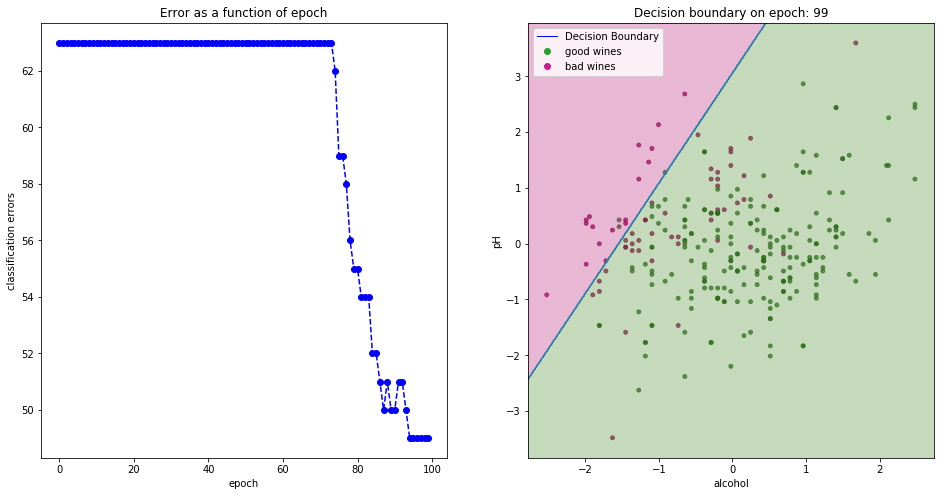

In [418]:
# ADALINE with StandardScaler
rd.seed(42)
df_nonsep = prep_data(df, ['alcohol', 'pH'], 'quality', 7, 4, StandardScaler())
nonsep_perf = train_adaline(df_nonsep, epochs=100)
plot_performance(nonsep_perf, df_nonsep, 7, 4, -1, False)

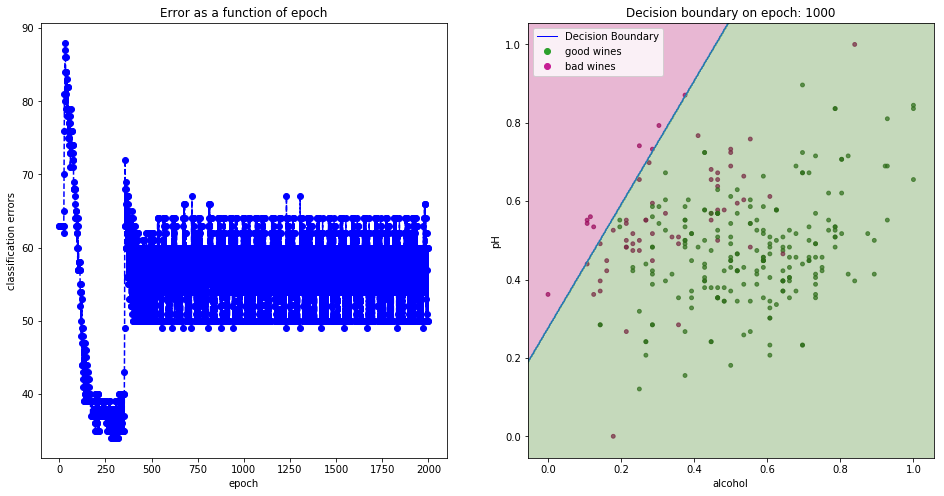

In [211]:
# ADALINE with MinMaxScaler
train_df = prep_data(df, ['alcohol', 'pH'], 'quality', 7, 4, MinMaxScaler())
# train perceptron
perf = train_adaline(train_df, learning_rate=.05, epochs=2000, batch_size=-1535135135)
# plot performance
plot_performance(perf, train_df, 7, 4, 1000, False)

## V.4 Hold-out and Cross-Validation
<br/>

**a) Hold-out split**

In [19]:
def train_test_split(data, test_size=.33, shuffle=True, random_state=None):
    """
    Split dataset into train/test dataframes (Hold-out validation)
    
    @param test_size: proportion of samples in test dataset
    @param shuffle: permute data before splitting
    @param random_state: seed for random number generator used for <shuffle>

    @returns: (train_dataframe, test_dataframe)
    """
    if shuffle:
        ind = data.sample(axis=0, frac=test_size, random_state=random_state).index  # indices of hold-out samples
        return data[~data.index.isin(ind)], data[data.index.isin(ind)]
    else:
        n_test_samples = math.ceil(data.shape[0] * test_size)
        return data.iloc[:-n_test_samples, :], data.iloc[-n_test_samples:, :]

**b) Cross-Validation split**

In [20]:
def k_fold_CV(data: pd.DataFrame, k=3, shuffle=True, random_state=None):
    """
    k-fold Cross-Validation split
    
    Notes:
        Cross-Validation used to measure generalization error. It is
        especially valuable if you have small dataset, since hold-out
        is prohibitively expensive in this setting.
    @returns: k tuples of (train_data, test_data) pairs
    """
    if k < 2 or k >= data.shape[0]:
        warnings.warn("1 < k < # of samples")
        return []
    folds = []
    fold_size = math.ceil(data.shape[0] / k)
    if shuffle:
        data = data.sample(frac=1, random_state=random_state)
        data.reset_index(inplace=True, drop=True)
    for i in range(k):
        lcut, rcut = fold_size * i, fold_size * (i + 1)
        holdout_df = data.iloc[lcut:rcut, :]
        train_df = data[~data.index.isin(holdout_df.index)]
        folds.append((train_df.reset_index(drop=True), holdout_df.reset_index(drop=True)))
    return folds

In [21]:
def train_adaline_cv(data, learning_rate=.01, epochs=0, batch_size=-1, k=1, test_size=.33, random_state=None):
    """
    Perform Hold-out/CV training and validation.
    
    @param k: Number of folds. If k=1, hold-out is performed
    @param test_size: fraction of samples to use for validation. Ignored if k > 1
    """
    if 'quality' not in data.columns:
        raise ValueError("<data> must contain target column `quality`")
    ada = Adaline(alpha=learning_rate, batch_size=batch_size, activation_function='sgn')
    if k == 1:
        df_train, df_val = train_test_split(data, random_state=random_state)
        X_train, y_train = df_train[[c for c in df_train.columns if c != 'quality']], df_train.quality
        X_val, y_val = df_val[[c for c in df_val.columns if c != 'quality']], df_val.quality
        ada.fit(X_train, y_train, epochs)
        print("Hold-out accuracy:", ada._acc(X_val, y_val))
    else:
        cv_acc = []
        for i, (df_train, df_val) in enumerate(k_fold_CV(data, k=k, random_state=random_state)):
            X_train, y_train = df_train[[c for c in df_train.columns if c != 'quality']], df_train.quality
            X_val, y_val = df_val[[c for c in df_val.columns if c != 'quality']], df_val.quality
            ada.fit(X_train, y_train, epochs)
            acc = ada._acc(X_val, y_val)
            cv_acc.append(acc)
            print("fold-{} accuracy: {}".format(i + 1, acc))
        print("Mean {}-fold accuracy: {}".format(k, sum(cv_acc)/len(cv_acc)))
    return ada.performance

In [408]:
# CV ADALINE with StandardScaler
df_nonsep = prep_data(df, ['alcohol', 'pH'], 'quality', 7, 4, StandardScaler())
nonsep_perf = train_adaline_cv(df_nonsep, epochs=300, k=7, batch_size=8, learning_rate=.5, random_state=42)

fold-1 accuracy: 0.925
fold-2 accuracy: 0.775
fold-3 accuracy: 0.9
fold-4 accuracy: 0.75
fold-5 accuracy: 0.85
fold-6 accuracy: 0.8
fold-7 accuracy: 0.625
Mean 7-fold accuracy: 0.8035714285714286


**c) ADALINE hyperparameters tuning using CV**
<br />

Empirically, there is no significant difference in models trained with different `batch_size`, as long as number of epochs is large enough. Optimal number of folds in k-fold CV is another hyperparameter, showing good performance when in range `[3, 6]`. `learning rate` should be kept within `[.001, .01]`

## V.5 Multi-dimensional setting

<br/>

**a) Train ADALINE with all features**
It's self-evident that adding more features improves model's accuracy.

In [524]:
df_all = prep_data(df, [c for c in df.columns if c != 'quality'], 'quality', 7, 4, StandardScaler())
all_perf = train_adaline_cv(df_all, epochs=600, k=7, random_state=42)

fold-1 accuracy: 0.9
fold-2 accuracy: 0.875
fold-3 accuracy: 0.925
fold-4 accuracy: 0.8
fold-5 accuracy: 0.95
fold-6 accuracy: 0.875
fold-7 accuracy: 0.875
Mean 7-fold accuracy: 0.8857142857142858


/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning:

Decision boundary can be rendered only for 2-feature dataset



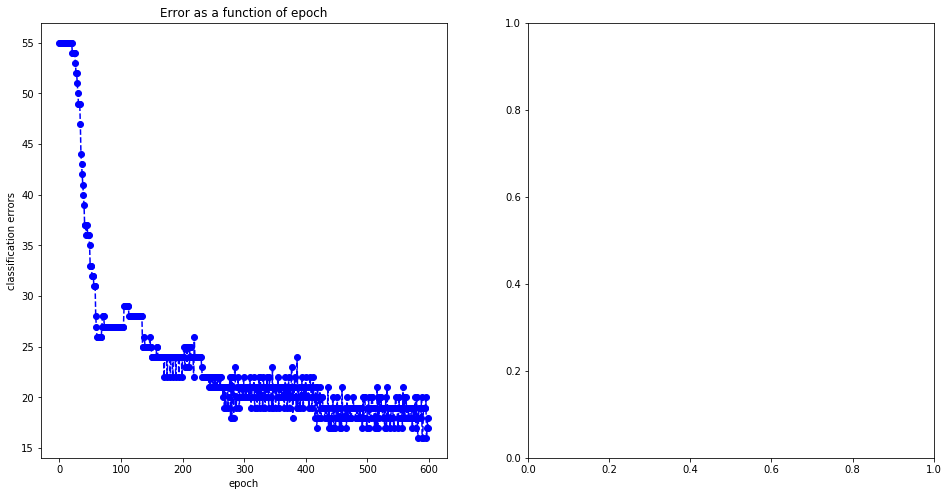

In [525]:
plot_performance(all_perf, df_all, 7, 4, -1, False)

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning:

Decision boundary can be rendered only for 2-feature dataset



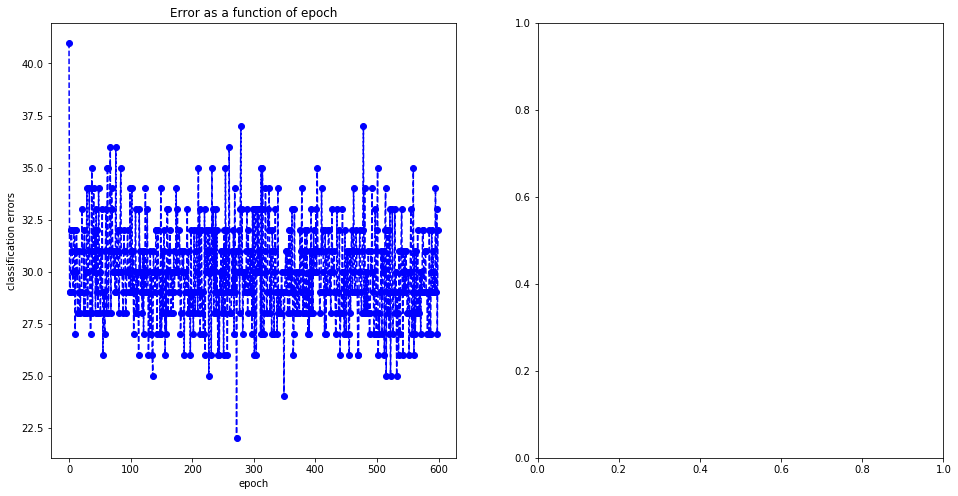

In [526]:
plot_performance(train_perceptron(df_all, epochs=600), df_all, 7, 4, -1, False)

**b) decision boundary in n-dimensional space**
<br />
Decision boundary is a hyper-surface, hence having one dimension less then the ambient space.
<br />
Thus, for:
* 3 factors -- 2D plane
* 7 factors -- 6-dimensional hyperplane
* 11 factors -- 10-dimensional hyperplane

## V.6 Pan-Galactic Gargle Blaster
<br />

**a) Fit Perceptron to data and plot it's performance**

In [22]:
good_thresh, bad_thresh = 6, 4

In [23]:
pggb_df = pd.read_csv('resources/Pan Galactic Gargle Blaster.csv', sep=';')

In [24]:
pggb_train = prep_data(pggb_df, ['wonderflonium', 'fallian marsh gas'], 'quality',
                       good_thresh, bad_thresh, StandardScaler())

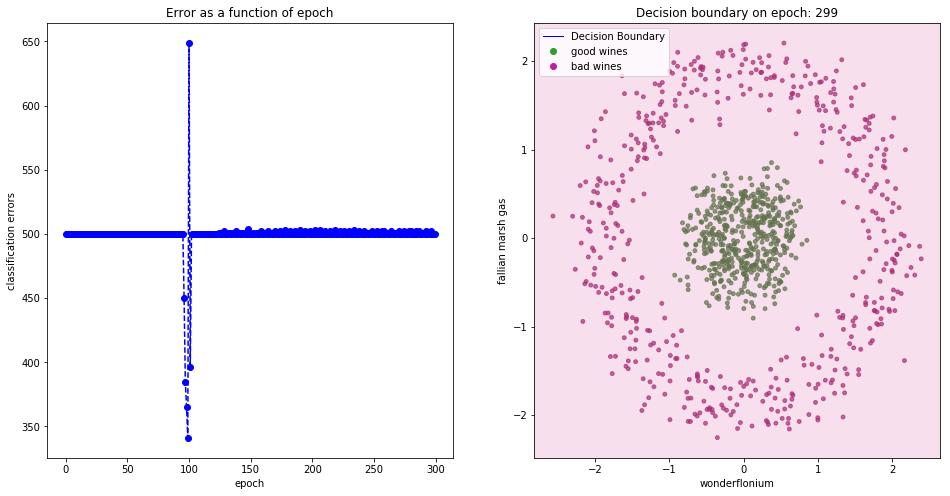

In [522]:
perf = train_adaline(pggb_train, epochs=300)
plot_performance(perf, pggb_train, good_thresh, bad_thresh, -1, False)

Here, the decision boundary must be circular, and both Perceptron/ADALINE will fail miserably to fit it. We can aid them by using **feature engineering** -- collection of techniques for manufacturing features. There is a simple trick that suits this dataset perfectly. We can add interaction term between our features. Let's call it `mlg9000` and define it as `wonderflonium` * `fallian marsh gas`. Let's also add `wonderflonium`^2 and `fallian marsh gas`^2.

In [25]:
# pggb_df['mlg9000'] = pggb_df[['wonderflonium', 'fallian marsh gas']].apply(lambda x: x[0] * x[1], axis=1)
pggb_df['wonderflonium^2'] = pggb_df['wonderflonium'].apply(lambda x: x ** 2)
pggb_df['fallian marsh gas^2'] = pggb_df['fallian marsh gas'].apply(lambda x: x ** 2)

In [26]:
feature_labels = [c for c in pggb_df.columns if c != 'quality']
scaler = StandardScaler()
pggb_train_v2 = prep_data(pggb_df, feature_labels, 'quality',
                          good_thresh, bad_thresh, scaler)

In [27]:
class Trainer:
    """
    Base class for binary classification training
    """
    def __init__(self, verbose=False, random_state=None, epochs=0, k=1):
        self.verbose = verbose
        self.random_state = random_state
        self.epochs = epochs
    
    def train(self, data, model, **params):
        """
        Create <model> instance with <params> passed to initializer
        and fit it to <data>.
        @return: performance of the model
        """
        m = model(epochs=self.epochs, **params)
        if 'quality' not in data.columns:
            raise ValueError("<data> must contain target column `quality`")
        ada = Adaline(alpha=learning_rate, batch_size=batch_size, activation_function='sgn')
        if k == 1:
            df_train, df_val = train_test_split(data, random_state=random_state)
            X_train, y_train = df_train[[c for c in df_train.columns if c != 'quality']], df_train.quality
            X_val, y_val = df_val[[c for c in df_val.columns if c != 'quality']], df_val.quality
            ada.fit(X_train, y_train, epochs)
            print("Hold-out accuracy:", ada._acc(X_val, y_val))
        else:
            cv_acc = []
            for i, (df_train, df_val) in enumerate(k_fold_CV(data, k=k, random_state=random_state)):
                X_train, y_train = df_train[[c for c in df_train.columns if c != 'quality']], df_train.quality
                X_val, y_val = df_val[[c for c in df_val.columns if c != 'quality']], df_val.quality
                ada.fit(X_train, y_train, epochs)
                acc = ada._acc(X_val, y_val)
                cv_acc.append(acc)
                print("fold-{} accuracy: {}".format(i + 1, acc))
            print("Mean {}-fold accuracy: {}".format(k, sum(cv_acc)/len(cv_acc)))


In [29]:
def plot_performance_nonlinear(performance, data, good_thresh, bad_thresh,
                     epoch=-1, save_plot=False, db_features=None, transformer=None):
    """
    Plot the performance of Perceptron/ADALINE on non-linear dataset
    
    @param db_features: If <data> contains more then two features, provide list of 2 features
                        to be used as axis when plotting decision boundary
    @param transformer: Transformer used during training (required for decision boundary)
    """
    errors = [epoch[1] for epoch in performance]
    epochs = [epoch[0] for epoch in performance]
    fig, axis = plt.subplots(ncols=2, figsize=(16, 8))
    # classification errors
    axis[0].plot(epochs, errors, 'bo--')
    axis[0].set_title("Error as a function of epoch")
    axis[0].set_xlabel("epoch")
    axis[0].set_ylabel("classification errors")

    # decision boundary
    if db_features is None and (len(data.columns) != 3 or 'quality' not in data.columns):
        warnings.warn("Decision boundary can be rendered only for 2-feature dataset")
        if save_plot:
            plt.savefig('performance_plot_{}.png'.format(str(dt.datetime.now())[:-7]))
        plt.show()
        return
    epoch, _, weights, bias = performance[-1 if epoch < 0 or epoch >= len(performance) else epoch]
    # create model from weights and bias
    ada = Adaline()
    ada.weights = weights
    ada.bias = bias
    xlabel, ylabel = db_features
    # Firstly, plot scatterplot to use it's limits
    x = transformer.transform(data[xlabel]) if transformer is not None else data[xlabel]
    y = transformer.transform(data[ylabel]) if transformer is not None else data[ylabel]
    f = axis[1].scatter(x, y, c=data.quality, s=15, alpha=.9, cmap='PiYG')
    axis[1].set_title("Decision boundary on epoch: {}".format(epoch))
    axis[1].set_xlabel(xlabel)
    axis[1].set_ylabel(ylabel)
    x_min, x_max = data[xlabel].min(), data[xlabel].max()
    y_min, y_max = data[ylabel].min(), data[ylabel].max()
    # Generating meshgrid without numpy is pain in the arse...
    # size is a `resolution` parameter. More points -> better decision boundary
    size = 500
    xx, yy = linspace(x_min - .2, x_max + .2, size), linspace(y_min - .2, y_max + .2, size)
    d = pd.DataFrame([[x , y, x**2, y**2] for x in xx for y in yy])
    if transformer is not None:
        d = transformer.transform(d)
    Z = pd.DataFrame(ada.predict(d).values.reshape((size, size))).values
    xx = transformer.transform(pd.Series(xx)) if transformer is not None else xx
    yy = transformer.transform(pd.Series(yy)) if transformer is not None else yy
    axis[1].contourf(xx, yy, Z, levels=2, cmap='PiYG', alpha=.3)
    axis[1].contour(xx, yy, Z, levels=[0, 1], cmap='tab10')
    # add legend manually
    from matplotlib.lines import Line2D  # to create legend artists manually
    legend_elems = [Line2D([0], [0], lw=1, color='blue', label='Decision Boundary'),
                    Line2D([0], [0], marker='o', lw=0, color='C2', label='Good Blaster'),
                    Line2D([0], [0], marker='o', lw=0, color='#c61d94', label='Bad Blaster')]
    axis[1].legend(handles=legend_elems, loc='upper left')
    if save_plot:
        plt.savefig('performance_plot_{}.png'.format(str(dt.datetime.now())[:-7]))
    plt.show()

In [32]:
perf_v2 = train_adaline(pggb_train_v2, epochs=300, random_state=42, batch_size=-1)

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Zero classification errors. Early stopping...


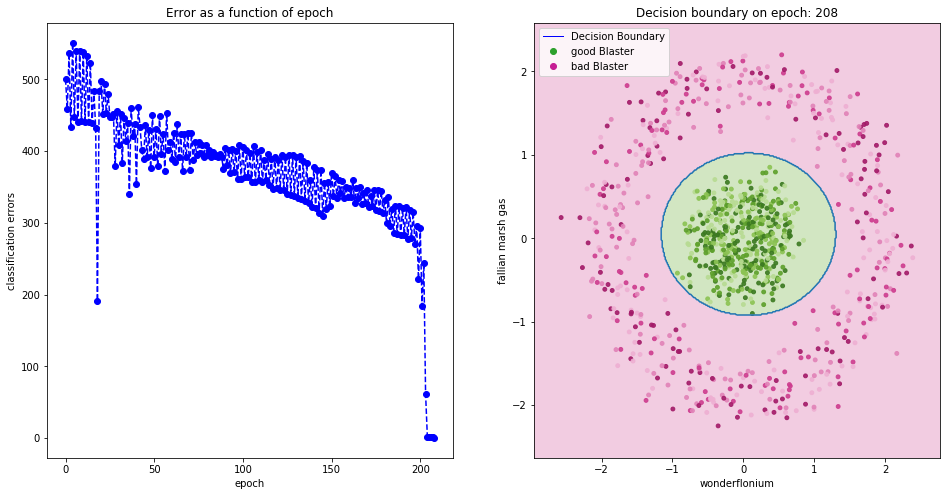

In [518]:
plot_performance_nonlinear(perf_v2, pggb_df,
                           good_thresh, bad_thresh,
                           -1, db_features=['wonderflonium', 'fallian marsh gas'],
                           save_plot=False, transformer=scaler)

## VI Bonuses
<br />

### VI.1 Cythonized Perceptron/ADALINE

### VI.2 Animated performance

In [34]:
from matplotlib import animation
from IPython.display import HTML

In [35]:
def animated_performance(performance, data, model, good_thresh, bad_thresh, db_features=None,
                         transformer=None, anim_save=False, nonlinear=True, size=50):
    """
    Animated plot of model's performance
    """
    epochs = [epoch[0] for epoch in performance]
    errors = [epoch[1] for epoch in performance]
    fig, axis = plt.subplots(ncols=2, figsize=(16, 8))
    axis[0].set_xlim(0, len(performance) + 3)
    axis[0].set_ylim(0, data.shape[0])
    axis[0].set_title("Error as a function of epoch")
    axis[0].set_xlabel("epoch")
    axis[0].set_ylabel("classification errors")

    err_epoch = axis[0].plot([], [], 'bo-', markersize=3, linewidth=1)  # initialize plot
    xlabel, ylabel = db_features if db_features is not None else data.columns[:2]
    x, y = data[xlabel], data[ylabel]
    if transformer is not None:
        x, y = transformer.transform(data[xlabel]), transformer.transform(data[ylabel])
    x_min, x_max = min(data[xlabel]), max(data[xlabel])
    y_min, y_max = min(data[ylabel]), max(data[ylabel])
    xx, yy = linspace(x_min - .2, x_max + .2, size), linspace(y_min - .2, y_max + .2, size)
    if nonlinear:
        d = pd.DataFrame([[x , y, x**2, y**2] for x in xx for y in yy])
    else:
        d = pd.DataFrame([[x, y] for x in xx for y in yy])
    if transformer is not None:
        d = transformer.transform(d)
        xx = transformer.transform(pd.Series(xx))
        yy = transformer.transform(pd.Series(yy))
    def animate(i):
        err_epoch[0].set_data(epochs[:i], errors[:i])
        epoch, _, weights, bias = performance[i]
        model.weights, model.bias = weights, bias
        Z = pd.DataFrame(model.predict(d).values.reshape((size, size))).values
        axis[1].clear()
        axis[1].scatter(x, y, c=data.quality, s=15, alpha=.7, cmap='PiYG')
        axis[1].contourf(xx, yy, Z, cmap='PiYG', alpha=.3)
        axis[1].contour(xx, yy, Z, levels=[0, 1], cmap='tab10')
        axis[1].set_title("Decision boundary on epoch: {}".format(epoch))
        from matplotlib.lines import Line2D  # to create legend artists manually
        legend_elems = [Line2D([0], [0], lw=1, color='blue', label='Decision Boundary'),
                    Line2D([0], [0], marker='o', lw=0, color='C2', label='Good wine'),
                    Line2D([0], [0], marker='o', lw=0, color='#c61d94', label='Bad wine')]
        axis[1].legend(handles=legend_elems, loc='upper left')
        axis[1].set_xlabel(xlabel)
        axis[1].set_ylabel(ylabel)

    anim = animation.FuncAnimation(fig, animate, frames=len(performance))
    if anim_save:
        anim.save('test_animation.html', writer='html')
    plt.close(fig)
    return anim

In [ ]:
anim = animated_performance(perf_v2, pggb_df, Adaline(),
                     good_thresh, bad_thresh,
                     db_features=['wonderflonium', 'fallian marsh gas'],
                     anim_save=True, transformer=scaler, size=300)

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [653]:
plt.rcParams['animation.embed_limit'] = 2  # to remove limit
HTML(anim.to_jshtml(fps=24))

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


Animation size has reached 2213449 bytes, exceeding the limit of 2097152.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [655]:
rd.seed(42)
s = StandardScaler()
df_nonsep = prep_data(df, ['alcohol', 'pH'], 'quality', 7, 4, s)
nonsep_perf = train_adaline(df_nonsep, epochs=100)
anim2 = animated_performance(nonsep_perf, df_nonsep, Adaline(), 7, 4, transformer=s)

In [656]:
HTML(anim2.to_jshtml(fps=24))

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning:

No contour levels were found within the data range.

Animation size has reached 2141245 bytes, exceeding the limit of 2097152.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
